# Scaling to multiple samples (Chapter 2)

This notebook covers the code and explanation for the following experiments in Chapter 2:
* Experiment 2F

==========================================================================
* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1

In [1]:
%matplotlib inline

In [1]:
import matplotlib.gridspec as grid_spec
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

from matplotlib import cm
from pylab import colorbar
from torch.distributions import Normal, MultivariateNormal

mpl.style.use("seaborn-deep")

In this notebook we extend the examples from Experiments 2B and 2D to utilize multiple samples.

In the following code, we will solve Bayes' Theorem with grid approximation where it is assumed that the parameters of the generative model have already been learnt. The aim of the code is for its setup to be as close as possible to the math notation in the accompanying text. 

Section 2.2 described five steps to be used in modeling. We will follow these steps in this notebook:
1. Define the experimental setting (states and outcomes)
2. Define the generative process
3. Define the generative model
4. Learn model parameters
5. Infer hidden states

## Experimental setting

We now begin Step 1: **Define the experimental setting (states and outcomes)**.

We will rely on the following variables:
* $x$: The true **hidden state** of the generative process.
* $y$: The **outcome** of a generative process, known as the **observation** for a generative model. This is the data the agent receives.

In this scenario the states of the generative process ($x$) denote the size of a food  source and the outcomes ($y$) are different levels of light intensity emitted from the food as a function of size. Using these observations, the agent needs to infer ("perceive") the hidden state of the generative process that generated the data it is receiving. 

## Experiment 2F: Bayesian inference with multiple samples and one state

In this experiment we use the following generative process:

$
\mathscr{E} = 
\begin{cases}
    \mu = 2x_ + 3                             & \text{Generating function} \\
    y_i \sim \mathcal{N}(\mu, \sigma^2 = 1)    & \text{Gaussian noise} \\
\end{cases}
$

And the following generative model:

$
\mathcal{M} = 
\begin{cases}
    p_{\mu_y, \sigma^2_y}(y_i  \mid x ) = \mathcal{N}(y_i ; \mu_y, \sigma^2_y) & \text{Likelihood} \\
    p_{\mu_y, \sigma^2_y}(x ) = \mathcal{N}(x ; \mu_x, \sigma^2_x) & \text{Prior on } x \\
    \mu_y = \beta_0 + \beta_1 x  & \text{Generating function} \\
    \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \}  & \text{Linear parameters} \\
    \phi := \left \{\sigma^2_y = 0.25, \mu_x = 4, \sigma^2_x = 0.25 \right \} & \text{Other parameters}
\end{cases}
$

In the above equations, the subscript $i$ now denotes the sample for $i = 1, \dots, n$.

Now we create the range of $x$ and the generating function as we have done before:

In [2]:
# Grid ranges (the range of values x can take)
x_min = 0.01
x_max = 5
x_points = 500

x_range = torch.linspace(start=x_min, end=x_max, steps=x_points)

# Define the generating function
def G(x, beta_0, beta_1):
    y = beta_1 * x + beta_0
    return y

As before, we first generate samples. However this time we specify the number of samples from the environment we wish to generate, $n$. Note that from now on, instead of `obs` we will refer to the vector of data points, $y_i$ in the code as `y_i`. We continue and create the log-likelihood and log-prior.

**Note**: The usage of `unsqueeze(1)` is a particular idiosyncracy of the `pytorch` distribution functions that requires that we change the dimension of the array slightly.

In [3]:
n                  = 30
x_true             = 2

# Sample generative process
torch.manual_seed(7867)
y_i = Normal(loc=G(x_true, beta_0=3, beta_1=2), scale=0.5).sample([n])

# Set up modeling objects
likelihood_mean    = G(x_range, beta_0=3, beta_1=2)
likelihood_noise   = 0.5
prior_mean         = 4
prior_noise        = 0.5 

# Define the components of the generative model
log_likelihood     = Normal(loc=likelihood_mean, scale=likelihood_noise).log_prob(y_i.unsqueeze(1))
log_prior          = Normal(loc=prior_mean, scale=prior_noise).log_prob(x_range)

Let's examine this log-likelihood's shape:

In [5]:
print(f"The shape of the log-likelihood is [{log_likelihood.shape[0]} x {log_likelihood.shape[1]}]")

The shape of the log-likelihood is [30 x 500]


This makes sense - it has 30 rows, one for each sample, and 500 columns, one for each point in our 500-point grid over $x$. Now if we want to compute the log-likelihood over all samples what we should do is take the sum *down* the rows. We can do this by using `sum(axis=0)`. Note that we are taking the *sum* because taking a logarithm transforms a product into a sum. So

$$
\prod_{i=1}^n p(y_i \mid x) = \sum_{i=1}^n \log p(y_i \mid x)
$$

Since we take the log over the prior, the multiplication by the prior becomes a sum. So we can add it to the sum over all the likelihoods

$$
p(y_i, x) = \sum_{i=1}^n \log p(y_i \mid x) + p(x).
$$

Now all we need to do is run Bayes' Theorem. We will make use of the **log-sum-exp** trick to quickly calculate the posterior distributions using logs.

In [6]:
# Calculate posterior using log-likelihood/prior
log_likelihood     = log_likelihood.sum(axis=0)  # Sum over the log-likelihood for all samples
log_gen_model      = log_likelihood + log_prior                                     
posterior          = np.exp(log_gen_model - max(log_gen_model))  

<Figure size 640x480 with 0 Axes>

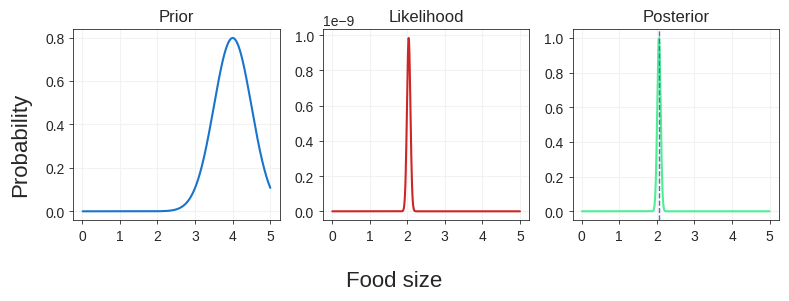

In [7]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range.tolist(), np.exp(log_prior), c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), np.exp(log_likelihood), c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Posterior mode and posterior axis
axes[2].axvline(x=(np.argmax(posterior) + 1) / 100, linestyle="dashed", linewidth=1)

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

In [8]:
mode = (np.argmax(posterior) + 1) / 100
print(f'The posterior mode is {mode}. This is the expected or inferred food size, the hidden state estimate with 30 observations (samples) from the generative process in the true state {x_true}.')

The posterior mode is 2.059999942779541. This is the expected or inferred food size, the hidden state estimate with 30 observations (samples) from the generative process in the true state 2.


You will note that the prediction is must better than the case with one sample. As we receive more and more data, posterior can be updated and become a better and better approximation of the true state as the variance shrinks.

## How to think about multiple likelihoods

Each of the likelihoods we generated for each sample denotes $p(y_i \mid x)$. If we plot each of these likelihoods we can see their credibility across $x$, food size, when $x^*=2$. Different samples of $y$ produce different looking likelihoods.

In [9]:
# Grid ranges (the range of values x can take)
x_min = 0.01
x_max = 5
x_points = 500

x_range = torch.linspace(start=x_min, end=x_max, steps=x_points)
y_range = G(x_range, beta_0=3, beta_1=2)

# First define the observation vector y
n      = 9
x_true = 2
y_i    = G(x=x_true, beta_0=3, beta_1=2) + Normal(loc=0, scale=0.5).sample([n])

# Set up likelihood
likelihood_mean    = G(x_range, beta_0=3, beta_1=2)
likelihood_noise   = 0.5
likelihood         = np.exp(Normal(loc=likelihood_mean, scale=likelihood_noise).log_prob(y_i.unsqueeze(1)))

Checking the shape, we see that it has $n=9$ rows and 500 columns, one for each across the range of $x$ in the grid.

In [10]:
likelihood.shape

torch.Size([9, 500])

Then we plot all of the likelihoods together.

**Note**: Plotting code heavily modified from matplotlib tutorial at: https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/

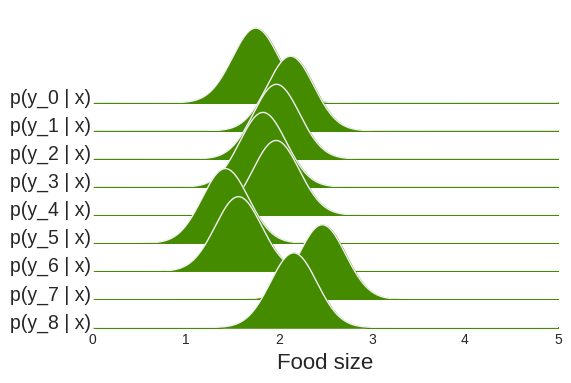

In [11]:
gs = grid_spec.GridSpec(len(likelihood) + 1,1)
fig = plt.figure(figsize=(6,4.5))

i = 0

ax_objs = []
for p in range(n):
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i + 1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_range, likelihood[p, :], color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x_range, likelihood[p, :], alpha=1, color="#458B00")

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,5)
    ax_objs[-1].set_ylim(0,1)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(likelihood)-1:
        ax_objs[-1].set_xlabel("Food size", fontsize=16)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
 
    ax_objs[-1].text(-0.02,0, f'p(y_{p} | x)', fontsize=14,ha="right")
    
    i += 1
    plt.grid(visible=None)

gs.update(hspace=-0.7)
plt.show()

Now we take the product over these likelihoods (or sum if it were a log-likelihood) and get the following:

<Figure size 640x480 with 0 Axes>

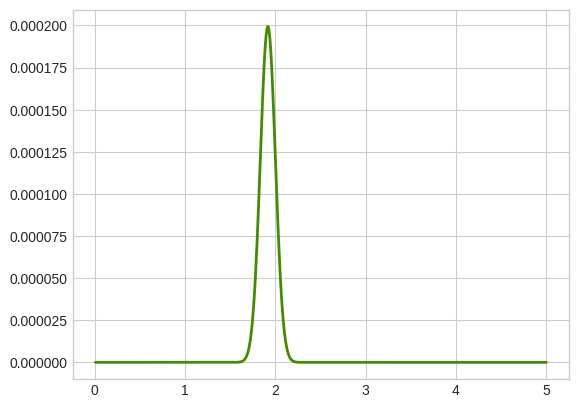

In [12]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1))

# Plot linear generating function on canvas
ax.plot(x_range, torch.prod(likelihood, axis=0),
        c="#458B00",
        linewidth=2)

## Inside the generative model

To create the joint distribution of the likelihood and prior for all cross combinations of $x$ and $y$ we will take the simple approach of looping over each value of $x$ and determining the conditional distribution $p(y \mid x)$ for each slice and them assembling together into a 500 x 500 matrix making up the grid over the two variables.

To begin with, we create a simple `agent()` function so we can repeatedly call it over a loop.

In [13]:
def agent(
    y: torch.LongTensor, 
    x: torch.FloatTensor, 
    x_range: torch.FloatTensor,
    prior_noise: float = 0.5) -> torch.FloatTensor:
    
    # Set up modeling objects
    likelihood_mean    = G(x_range, beta_0=3, beta_1=2)
    likelihood_noise   = 0.5
    prior_mean         = x
    prior_noise        = prior_noise
    
    # Define the components of the generative model
    log_likelihood     = Normal(loc=likelihood_mean, scale=likelihood_noise).log_prob(y)
    log_prior          = Normal(loc=prior_mean, scale=prior_noise).log_prob(x_range)
    
    # Calculate generative model
    log_gen_model      = log_likelihood + log_prior                                     
    
    return np.exp(log_gen_model).numpy()    

Now we are going to loop all values of x and collect the probabilites together into a 2D array.

In [14]:
probs = []

# Calculate the likelihood for all values of x and collect them
for x in x_range:
    # Sample generative process as specified true state to get observation
    E = Normal(loc=G(x, beta_0=3, beta_1=2), scale=0.5)
    torch.manual_seed(7867)
    y = E.sample()
    
    # Infer
    gen_model = agent(y, x, x_range)
    probs.append(gen_model)

probs = np.array(probs)   # Rows = x, cols = y

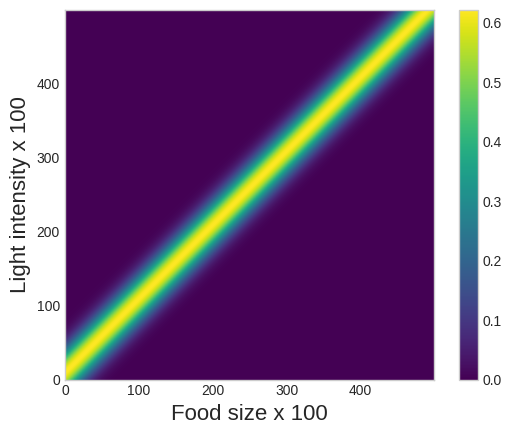

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(probs, origin="lower", cmap="viridis")
colorbar(im)

plt.xlabel("Food size x 100", fontsize=16)
plt.ylabel("Light intensity x 100", fontsize=16)
plt.grid(None)

Next we check to see the effect of the prior and how it encodes the notion that certain states may be more likely than others. To do this we set re run the agent from before but pass in a prior each time the generative model is run. This way all generative models will be biased with a credibility pointing toward a specific value of $x$. The effect is less strong the more samples we have.

In [16]:
# Make the previous figure a function

def get_gen_model(x_range, prior, prior_noise=0.5):
    probs = []
    # Calculate the likelihood for all values of x and collect them
    for x in x_range:
        # Sample generative process as specified true state to get observation
        E = Normal(loc=G(x, beta_0=3, beta_1=2), scale=0.5)
        torch.manual_seed(7867)
        y = E.sample()
        
        # Infer
        gen_model = agent(y=y, x=prior, x_range=x_range, prior_noise=prior_noise)
        probs.append(gen_model)

    probs = np.array(probs)   # Rows = x, cols = y
    
    return probs

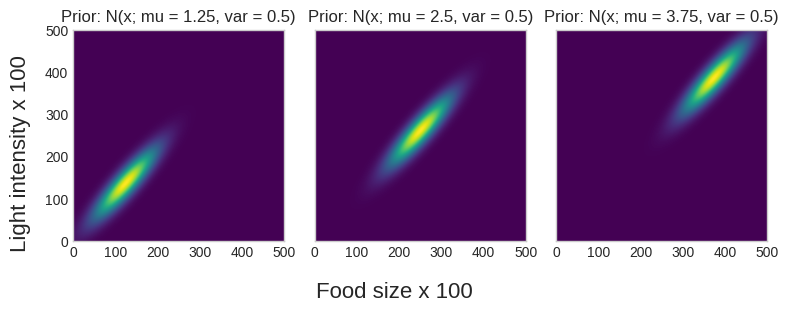

In [18]:
probs_1 = get_gen_model(x_range, 1.25)
probs_2 = get_gen_model(x_range, 2.5)
probs_3 = get_gen_model(x_range, 3.75)
# probs_4 = get_gen_model(x_range, 5)

fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,6.5), sharey=True)
axes[0].imshow(probs_1, origin="lower", cmap="viridis")
axes[1].imshow(probs_2, origin="lower", cmap="viridis")
axes[2].imshow(probs_3, origin="lower", cmap="viridis")

# Titles
axes[0].set_title("Prior: N(x; mu = 1.25, var = 0.5)")
axes[1].set_title("Prior: N(x; mu = 2.5, var = 0.5)")
axes[2].set_title("Prior: N(x; mu = 3.75, var = 0.5)")

# Tick range and grid
for ax in axes:
    ax.yaxis.set_ticks(np.arange(0, 600, 100))
    ax.xaxis.set_ticks(np.arange(0, 600, 100))
    ax.grid(None)

# Labels    
fig.supxlabel("Food size x 100", fontsize=16, y=0.27)
fig.supylabel("Light intensity x 100", fontsize=16)
   
fig.tight_layout()

Finally, we view the model in three dimensions which offers a slightly different perspective.

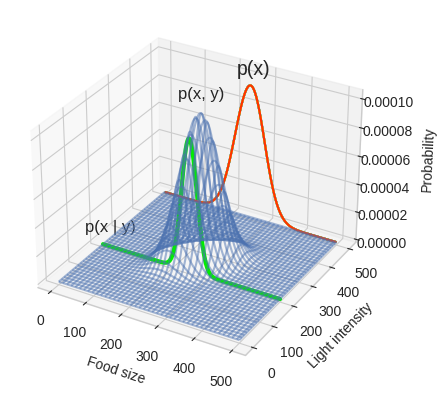

In [19]:
# Set up grid
X = np.linspace(0, 500, 500)
Y = np.linspace(0, 500, 500)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X 
pos[:, :, 1] = Y

# Set covariance matrix and joint distributions (Z)
cov_matrix = torch.tensor(np.array([[1764., 882.], [882., 1764.]]))

Z = MultivariateNormal(
    loc=torch.tensor([250, 250]),
    covariance_matrix=cov_matrix).log_prob(torch.tensor(pos))

fig = plt.figure()
ax = plt.subplot(projection='3d')

ax.plot_wireframe(X, Y, np.exp(Z), cmap='viridis', 
                  rstride=12, cstride=12, alpha=0.5)

# Plot prior
prior = np.exp(Z).sum(axis=0) / 100
ax.contour(X, Y, np.tile(prior, [len(prior), 1]), zdir='y', offset=500, cmap=cm.jet)

# Plot likelihood
likelihood = Normal(
    loc= G(x_range, beta_0=3, beta_1=2), 
    scale=0.5).log_prob(torch.tensor(8))

likelihood = torch.tensor(np.exp(likelihood.tolist()))
posterior = likelihood * prior / sum(likelihood*prior)

ax.plot3D(
    np.linspace(0, 500, 500),
    200 * np.ones(500),
    posterior / 200, lw=3, c="#00ee00")

# ax.plot3D(
#     np.linspace(0, 500, 500),
#     275 * np.ones(500), 
#     likelihood / 9000, lw=3, c="#8B008B")

# Axis labels
ax.set_xlabel("Food size")
ax.set_ylabel("Light intensity")
ax.set_zlabel("Probability", labelpad=10)

# Add distribution labels
ax.text(210, 500, 0.0001, "p(x)", fontsize=14)
# ax.text(0, 200, 0.00002, r"$p(y \mid x)$", fontsize=12)
ax.text(0, 120, 0.00002, "p(x | y)", fontsize=12)
ax.text(190, 250, 0.00011, "p(x, y)", fontsize=12)

plt.show()
